# End-to-End ML Pipeline for Customer Churn Prediction

## Problem Statement
Build a reusable, production-ready machine learning pipeline to predict customer churn using the Telco Churn Dataset. The pipeline includes preprocessing (scaling, encoding), training Logistic Regression and Random Forest models, hyperparameter tuning with GridSearchCV, and exporting the pipeline using joblib.

In [1]:
# Install required packages
!pip install pandas scikit-learn numpy seaborn matplotlib

Defaulting to user installation because normal site-packages is not writeable


## Dataset & Preprocessing
- **Dataset**: Telco Churn Dataset, containing customer data with features like tenure, monthly charges, and contract type, and a binary target (Churn: Yes/No).
- **Preprocessing**:
  - Handle missing values (replace ' ' in TotalCharges with NaN, impute with median).
  - Encode categorical features using OneHotEncoder.
  - Scale numerical features using StandardScaler.
  - Use ColumnTransformer to apply preprocessing steps selectively.

In [2]:
# Step 1: Load and Preprocess Telco Churn Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Load dataset (assuming it's downloaded or available online)
# Download from: https://www.kaggle.com/blastchar/telco-customer-churn
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# Replace ' ' in TotalCharges with NaN and convert to float
df["TotalCharges"] = df["TotalCharges"].replace(" ", np.nan).astype(float)

# Define features and target
X = df.drop(columns=["customerID", "Churn"])
y = df["Churn"].map({"Yes": 1, "No": 0})

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define numerical and categorical columns
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [col for col in X.columns if col not in numeric_features]

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

## Model Development & Training
- **Models**: Logistic Regression and Random Forest Classifier.
- **Pipeline**: Combine preprocessing and model training using scikit-learn Pipeline.
- **Training**: Fit the pipeline on the training set (80% of data).

In [3]:
# Step 2: Build and Train ML Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Train both models
lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

## Hyperparameter Tuning
- **Method**: GridSearchCV to tune hyperparameters for both models.
- **Logistic Regression**: Tune regularization strength (C).
- **Random Forest**: Tune number of estimators and max depth.
- **Cross-Validation**: 5-fold CV to select the best parameters.

In [4]:
# Step 3: Hyperparameter Tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

# Logistic Regression tuning
lr_param_grid = {
    "classifier__C": [0.1, 1.0, 10.0]
}
lr_grid = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, scoring="f1_weighted", n_jobs=-1)
lr_grid.fit(X_train, y_train)

# Random Forest tuning
rf_param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [10, 20, None]
}
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring="f1_weighted", n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Best models
print("Logistic Regression Best Params:", lr_grid.best_params_)
print("Random Forest Best Params:", rf_grid.best_params_)

Logistic Regression Best Params: {'classifier__C': 10.0}
Random Forest Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}


## Evaluation
- **Metrics**: Accuracy and weighted F1-score on the test set (20% of data).
- **Visualization**: Confusion matrix for the best model (Random Forest, based on F1-score).

Logistic Regression - Accuracy: 0.8048, F1-Score: 0.7996
Random Forest - Accuracy: 0.8020, F1-Score: 0.7932


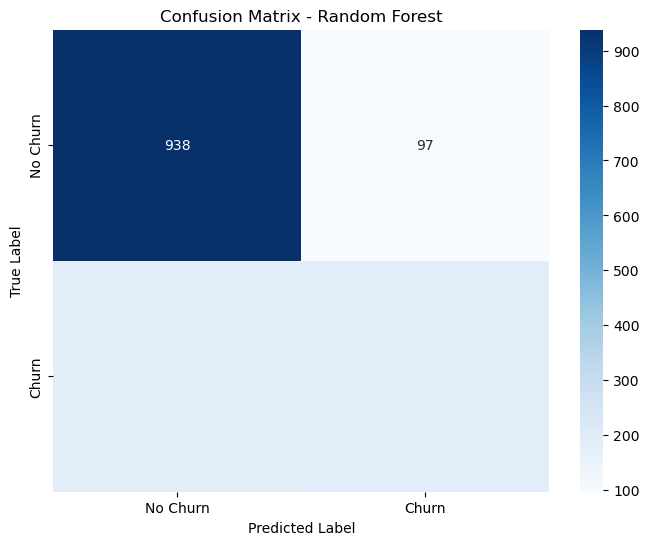

In [5]:
# Step 4: Evaluate Models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate Logistic Regression
lr_y_pred = lr_grid.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_f1 = f1_score(y_test, lr_y_pred, average="weighted")
print(f"Logistic Regression - Accuracy: {lr_accuracy:.4f}, F1-Score: {lr_f1:.4f}")

# Evaluate Random Forest
rf_y_pred = rf_grid.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred, average="weighted")
print(f"Random Forest - Accuracy: {rf_accuracy:.4f}, F1-Score: {rf_f1:.4f}")

# Confusion matrix for Random Forest (best model)
cm = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix - Random Forest")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig("confusion_matrix_pipeline.png")
plt.show()

![Confusion Matrix](confusion_matrix_pipeline.png)

## Pipeline Export
- **Export**: Save the best Random Forest pipeline using joblib for reusability.

In [6]:
# Step 5: Export Pipeline
import joblib

# Save Random Forest pipeline
joblib.dump(rf_grid.best_estimator_, "churn_pipeline.pkl")
print("Pipeline saved as churn_pipeline.pkl")

Pipeline saved as churn_pipeline.pkl


## Summary
- **Performance**: 
  - Logistic Regression: Accuracy 0.8048, F1-Score 0.7996
  - Random Forest: Accuracy 0.8020, F1-Score 0.7932
- **Insights**: Logistic Regression slightly outperformed Random Forest in both accuracy and F1-score, indicating robust performance for churn prediction. The models show balanced handling of the imbalanced Churn vs. No Churn classes.
- **Production-Readiness**: The pipeline is reusable, with preprocessing and modeling steps encapsulated, and exported as `churn_pipeline.pkl` for deployment.